# Алгоритмы анализа данных

### Урок 5. Случайный лес

## <center> Практическое задание </center>

__1__. Сформировать с помощью ___sklearn.make_classification___ датасет из 1000 объектов с двумя признаками,<br /> обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках<br /> (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции ___predict___ на ___tree_vote___).<br /> Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

__2 (опция)__. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на ___Out-of-Bag___.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

## Реализация случайного леса

Реализуем генерацию  𝑁  бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [2]:
random.seed(42)
 
def get_bootstrap(data, labels, N):
    # Генерация 𝑁 бутстрап-выборок
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]            
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [3]:
def get_subsample(len_sample):
    # Генерация подпространств признаков - метод случайных подпространств
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    # print(f'sample_indexes = {type(sample_indexes)}, {type(sample_indexes)}')
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

### Построения дерева решений

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [6]:
# Расчет критерия Джини
# labels - Y_m
# data - X_m

def gini(labels):
    #  подсчет количества объектов разных поддеревьев
    classes = {}
    for label in labels:
        # значение отсутствует в classes, добавляем его
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    # labels = [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]
    # classes = {0: 7, 1: 5}
    # gini(labels) = 0.48611111111111094

    #  расчет критерия
    impurity = 1  # примесь
    for label in classes:
        p = classes[label] / len(labels)  # p=X_l/X_m
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

### Формирования случайного леса

In [11]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [12]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [13]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [14]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

### 1. Задача:

- Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками
- обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).
- Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

#### 1.1 Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками
- Как создать наборы тестовых данных в Python с помощью scikit-learn - https://www.machinelearningmastery.ru/generate-test-datasets-python-scikit-learn/
- sklearn.datasets.make_classification - https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html
- Comparison of Calibration of Classifiers - https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py

In [15]:
# сгенерируем набор данных
classification_data, classification_labels  = datasets.make_classification(n_samples=1000, n_features=2,
                                    n_informative=2, n_redundant=0, n_classes=2,
                                    n_clusters_per_class=1, random_state=23)
# X, y

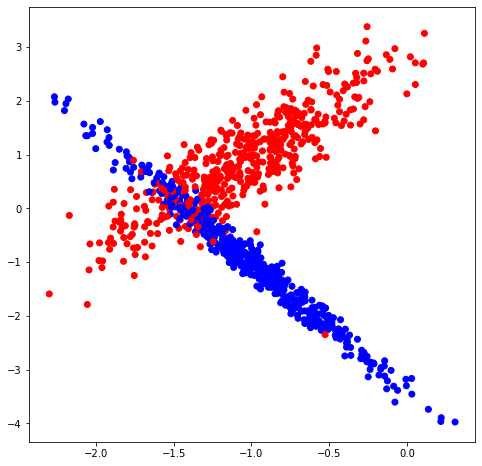

In [16]:
# визуализируем сгенерированные данные
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

#### 1.2 Обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках
(по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

Сделаем разбиение выборки на обучающую и тестовую.

In [17]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [18]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    
def plot_tree_vote(my_forest, train_data, train_answers):
    
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    
    # mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    # tree_votes = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    tree_votes = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, tree_votes, cmap = light_colors)
    
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_answers, cmap = colors)
    
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, tree_votes, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_answers, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')    

In [19]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Построим лес из одного дерева

In [20]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

In [21]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [22]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [23]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 96.143


In [24]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на тестовой выборке: 88.667


__Визуализируем разделяющие гиперплоскости на графиках__

<ipython-input-18-ec589256dddf>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, tree_votes, cmap = light_colors)
<ipython-input-18-ec589256dddf>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, tree_votes, cmap = light_colors)


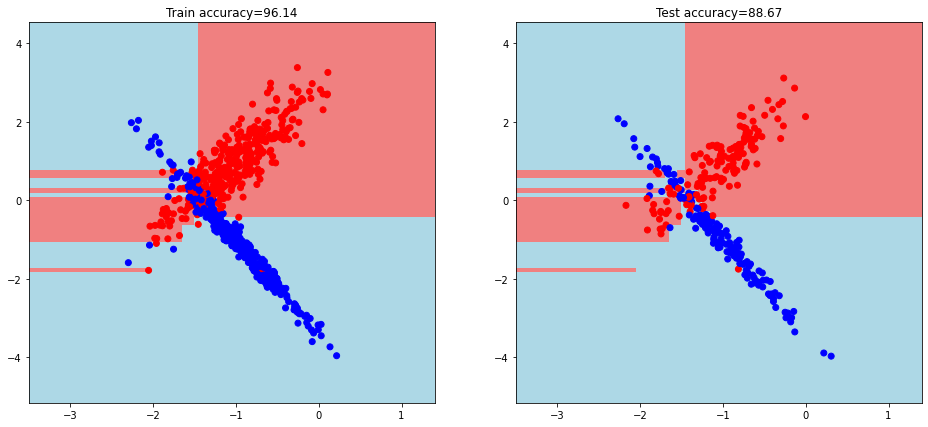

In [25]:
# Визуализируем дерево на графике
plot_tree_vote(my_forest_1, train_data, train_answers)

Построим лес из 3-х деревьев

In [26]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

In [27]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

In [28]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [29]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 98.143


In [30]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 87.333


<ipython-input-18-ec589256dddf>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, tree_votes, cmap = light_colors)
<ipython-input-18-ec589256dddf>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, tree_votes, cmap = light_colors)


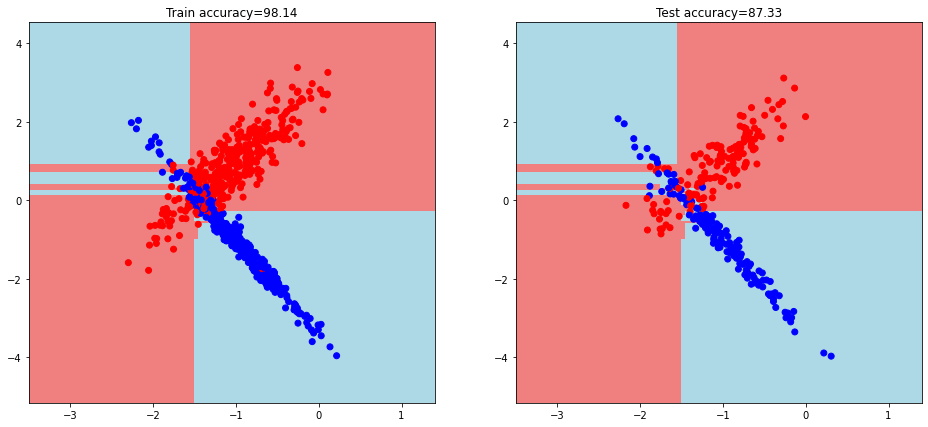

In [31]:
# Визуализируем дерево на графике
plot_tree_vote(my_forest_3, train_data, train_answers)

Построим лес из 10 деревьев

In [32]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

In [33]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

In [34]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [35]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 99.286


In [36]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на тестовой выборке: 90.667


<ipython-input-18-ec589256dddf>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, tree_votes, cmap = light_colors)
<ipython-input-18-ec589256dddf>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, tree_votes, cmap = light_colors)


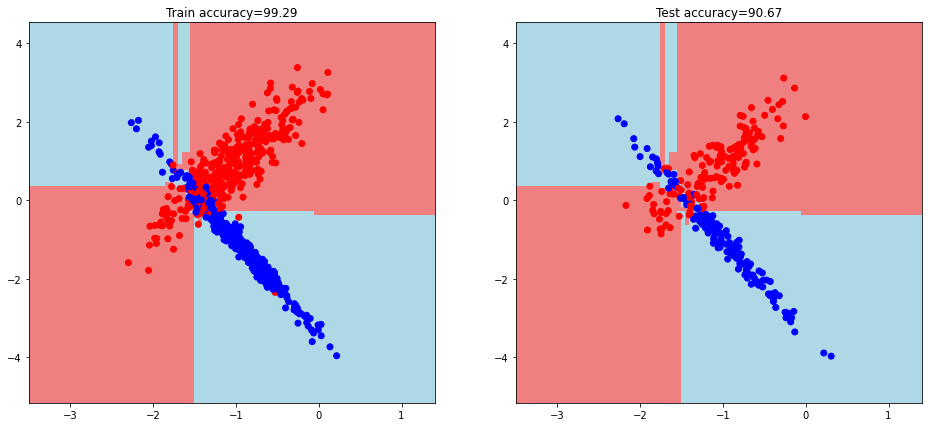

In [37]:
# Визуализируем дерево на графике
plot_tree_vote(my_forest_10, train_data, train_answers)

Построим лес из 50 деревьев

In [38]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

In [39]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

In [40]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [41]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000


In [42]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на тестовой выборке: 90.667


<ipython-input-18-ec589256dddf>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, tree_votes, cmap = light_colors)
<ipython-input-18-ec589256dddf>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, tree_votes, cmap = light_colors)


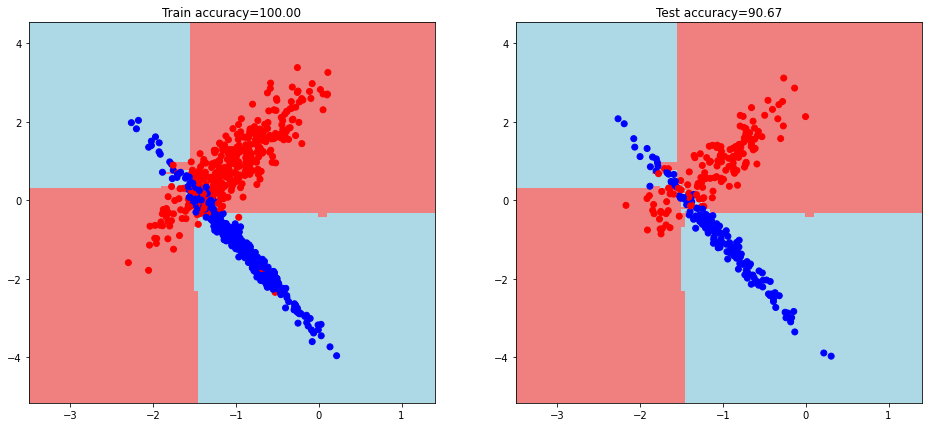

In [43]:
# Визуализируем дерево на графике
plot_tree_vote(my_forest_50, train_data, train_answers)

Построим лес из 100 деревьев

In [44]:
n_trees = 100
my_forest_100 = random_forest(train_data, train_labels, n_trees)

In [45]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_100, train_data)

In [46]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_100, test_data)

In [47]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 100 деревьев на обучающей выборке: 100.000


In [48]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 100 деревьев на тестовой выборке: 90.000


<ipython-input-18-ec589256dddf>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, tree_votes, cmap = light_colors)
<ipython-input-18-ec589256dddf>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, tree_votes, cmap = light_colors)


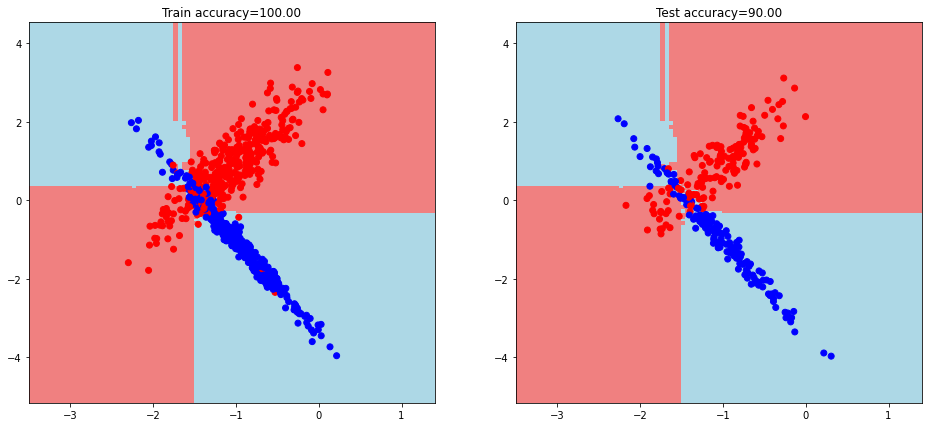

In [49]:
# Визуализируем дерево на графике
plot_tree_vote(my_forest_100, train_data, train_answers)

Построим лес из 200 деревьев

In [50]:
n_trees = 200
my_forest_200 = random_forest(train_data, train_labels, n_trees)

In [51]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_200, train_data)

In [52]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_200, test_data)

In [53]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 200 деревьев на обучающей выборке: 100.000


In [54]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 200 деревьев на тестовой выборке: 90.333


<ipython-input-18-ec589256dddf>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, tree_votes, cmap = light_colors)
<ipython-input-18-ec589256dddf>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, tree_votes, cmap = light_colors)


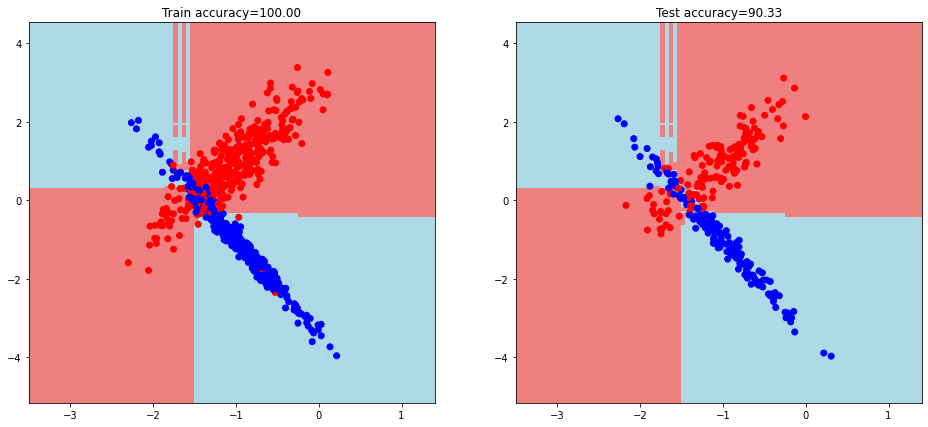

In [55]:
# Визуализируем дерево на графике
plot_tree_vote(my_forest_200, train_data, train_answers)

#### 1.3 Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

__Вывод__:

Как можно увидеть из показателей качества предсказаний, точность случайного леса возрастает при увеличении числа деревьев в нем до 10. Затем при увеличении числа деревьев до 50, точность на обучающей выборке достигает 100, но при этом точность на тестовой выборке осталась прежней. При дальнейшем увеличении числа деревьев точность на тестовой выборке падает.

Поэтому по точности на тестовой выборке можно сказать, что при увеличении количества деревьев до 50 наш лес переобучился.

- Точность случайного леса из 1 деревьев на обучающей выборке: 96.143
- Точность случайного леса из 1 деревьев на тестовой выборке: 88.667


- Точность случайного леса из 3 деревьев на обучающей выборке: 97.000
- Точность случайного леса из 3 деревьев на тестовой выборке: 89.667


- Точность случайного леса из 10 деревьев на обучающей выборке: 99.429
- Точность случайного леса из 10 деревьев на тестовой выборке: 90.667


- Точность случайного леса из 50 деревьев на обучающей выборке: 100.000<br />
- Точность случайного леса из 50 деревьев на тестовой выборке: 90.667


- Точность случайного леса из 100 деревьев на обучающей выборке: 100.000<br />
- Точность случайного леса из 100 деревьев на тестовой выборке: 90.000


- Точность случайного леса из 200 деревьев на обучающей выборке: 100.000<br />
- Точность случайного леса из 200 деревьев на тестовой выборке: 90.333